# Airline Routes Network Analysis

This notebook analyzes the airline routes network from the OpenFlights dataset.
It creates a network graph and computes various network statistics including:
- Degree distribution
- Top 10 airports by different centrality measures

**Data format (CSV):**
Airline, Airline ID, Source airport, Source airport ID, Destination airport, 
Destination airport ID, Codeshare, Stops, Equipment


# Airline Route Database

(Source: https://openflights.org/data)

As of June 2014, the OpenFlights/Airline Route Mapper Route Database contains 67663 routes between 3321 airports on 548 airlines spanning the globe, as shown in the map above. Each entry contains the following information:

- Airline	2-letter (IATA) or 3-letter (ICAO) code of the airline.
- Airline ID	Unique OpenFlights identifier for airline (see Airline).
- Source airport	3-letter (IATA) or 4-letter (ICAO) code of the source airport.
- Source airport ID	Unique OpenFlights identifier for source airport (see Airport)
- Destination airport	3-letter (IATA) or 4-letter (ICAO) code of the destination airport.
- Destination airport ID	Unique OpenFlights identifier for destination airport (see Airport)
- Codeshare	"Y" if this flight is a codeshare (that is, not operated by Airline, but another carrier), empty otherwise.
- Stops	Number of stops on this flight ("0" for direct)
- Equipment	3-letter codes for plane type(s) generally used on this flight, separated by spaces

The data is UTF-8 encoded. The special value \N is used for "NULL" to indicate that no value is available, and is understood automatically by MySQL if imported.

## Notes:
Routes are directional: if an airline operates services from A to B and from B to A, both A-B and B-A are listed separately. Routes where one carrier operates both its own and codeshare flights are listed only once.

##Sample entries
- BA,1355,SIN,3316,LHR,507,,0,744 777
- BA,1355,SIN,3316,MEL,3339,Y,0,744
- TOM,5013,ACE,1055,BFS,465,,0,320

Route maps for airports and airlines can be viewed by searching for their names or code in the website's Search box; alternatively, check out the alphabetical list of all covered airports and airlines.



## Import Libraries

In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import seaborn as sns

# Set matplotlib to display plots inline
%matplotlib inline

# Set style for better looking plots
plt.style.use('default')
sns.set_palette("husl")

## Data Loading Functions

In [3]:
def load_airline_data(filepath):
    """
    Load airline routes data from CSV file.
    
    Args:
        filepath (str): Path to the airline routes data file
        
    Returns:
        pandas.DataFrame: Loaded and cleaned data
    """
    # Define column names based on the data description
    columns = [
        'airline_code', 'airline_id', 'source_airport', 'source_airport_id',
        'dest_airport', 'dest_airport_id', 'codeshare', 'stops', 'equipment'
    ]
    
    # Load data
    print("Loading airline routes data...")
    df = pd.read_csv(filepath, names=columns, na_values=['\\N']) #pandas provides easy way to load csv file with custom column names and missing value indicator
    
    print(f"Loaded {len(df)} routes") #each line is a route, so it's the length of our dataframe
    print(f"Data shape: {df.shape}")
    
    # Remove rows with missing airport codes
    df_clean = df.dropna(subset=['source_airport', 'dest_airport'])
    print(f"After removing missing airport codes: {len(df_clean)} routes")
    
    return df_clean

## Network Creation Functions

In [6]:
def create_airport_network(df):
    """
    Create a network graph from airline routes data.
    
    Args:
        df (pandas.DataFrame): Airline routes data
        
    Returns:
        networkx.Graph: Undirected graph of airport connections
    """
    print("Creating airport network...")
    
    # Create undirected graph (treating routes as bidirectional connections)
    G = nx.Graph()
    
    # Add edges for each route
    for _, row in df.iterrows():
        source = row['source_airport']
        dest = row['dest_airport']
        
        # Skip self-loops
        if source != dest:
            if G.has_edge(source, dest):
                # Increment weight if edge already exists
                G[source][dest]['weight'] += 1
            else:
                # Add new edge with weight 1
                G.add_edge(source, dest, weight=1)
    
    print(f"Network created with {G.number_of_nodes()} airports and {G.number_of_edges()} connections")
    
    return G

## Visualization Functions

In [5]:
def plot_degree_distribution(G):
    """
    Plot the degree distribution of the network.
    
    Args:
        G (networkx.Graph): Network graph
    """
    print("Plotting degree distribution...")
    
    # Get degree sequence
    degrees = [G.degree(n) for n in G.nodes()]
    degree_counts = Counter(degrees)
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Linear scale plot
    degrees_list = list(degree_counts.keys())
    counts_list = list(degree_counts.values())
    
    ax1.bar(degrees_list, counts_list, alpha=0.7, color='skyblue', edgecolor='black')
    ax1.set_xlabel('Degree')
    ax1.set_ylabel('Number of Airports')
    ax1.set_title('Degree Distribution (Linear Scale)')
    ax1.grid(True, alpha=0.3)
    
    # Log-log scale plot
    ax2.loglog(degrees_list, counts_list, 'bo', alpha=0.7, markersize=4)
    ax2.set_xlabel('Degree (log scale)')
    ax2.set_ylabel('Number of Airports (log scale)')
    ax2.set_title('Degree Distribution (Log-Log Scale)')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('degree_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print basic statistics
    print(f"\nDegree Distribution Statistics:")
    print(f"Mean degree: {np.mean(degrees):.2f}")
    print(f"Median degree: {np.median(degrees):.2f}")
    print(f"Max degree: {max(degrees)}")
    print(f"Min degree: {min(degrees)}")
    print(f"Standard deviation: {np.std(degrees):.2f}")

## Centrality Analysis Functions

In [7]:
def calculate_centrality_measures(G):
    """
    Calculate various centrality measures for the network.
    
    Args:
        G (networkx.Graph): Network graph
        
    Returns:
        dict: Dictionary containing centrality measures
    """
    print("Calculating centrality measures...")
    
    centralities = {}
    
    # Degree centrality
    print("  - Degree centrality...")
    centralities['degree'] = nx.degree_centrality(G)
    
    # Betweenness centrality (using sampling for large networks)
    print("  - Betweenness centrality...")
    if G.number_of_nodes() > 1000:
        # Use sampling for large networks to speed up computation
        k = min(1000, G.number_of_nodes())
        centralities['betweenness'] = nx.betweenness_centrality(G, k=k)
        print(f"    (using sampling with k={k} nodes)")
    else:
        centralities['betweenness'] = nx.betweenness_centrality(G)
    
    # Closeness centrality
    print("  - Closeness centrality...")
    # Only calculate for the largest connected component
    largest_cc = max(nx.connected_components(G), key=len)
    G_largest = G.subgraph(largest_cc)
    closeness_largest = nx.closeness_centrality(G_largest)
    
    # Extend to full graph with 0 for disconnected nodes
    centralities['closeness'] = {node: closeness_largest.get(node, 0) for node in G.nodes()}
    
    # Eigenvector centrality
    print("  - Eigenvector centrality...")
    try:
        centralities['eigenvector'] = nx.eigenvector_centrality(G_largest, max_iter=1000)
        # Extend to full graph with 0 for disconnected nodes
        centralities['eigenvector'] = {node: centralities['eigenvector'].get(node, 0) for node in G.nodes()}
    except nx.PowerIterationFailedConvergence:
        print("    Warning: Eigenvector centrality failed to converge, using PageRank instead")
        centralities['eigenvector'] = nx.pagerank(G)
    
    return centralities

## Results Display Functions

In [8]:
def display_top_airports(centralities, top_n=10):
    """
    Display top N airports for each centrality measure.
    
    Args:
        centralities (dict): Dictionary of centrality measures
        top_n (int): Number of top airports to display
    """
    print(f"\n{'='*60}")
    print(f"TOP {top_n} AIRPORTS BY CENTRALITY MEASURES")
    print(f"{'='*60}")
    
    for measure_name, measure_values in centralities.items():
        print(f"\n{measure_name.upper()} CENTRALITY:")
        print("-" * 40)
        
        # Sort airports by centrality value
        sorted_airports = sorted(measure_values.items(), key=lambda x: x[1], reverse=True)
        
        for i, (airport, value) in enumerate(sorted_airports[:top_n], 1):
            print(f"{i:2d}. {airport:4s} - {value:.6f}")

In [9]:
def network_summary(G, df):
    """
    Print a summary of the network properties.
    
    Args:
        G (networkx.Graph): Network graph
        df (pandas.DataFrame): Original data
    """
    print(f"\n{'='*60}")
    print("NETWORK SUMMARY")
    print(f"{'='*60}")
    
    print(f"Number of airports (nodes): {G.number_of_nodes()}")
    print(f"Number of connections (edges): {G.number_of_edges()}")
    print(f"Number of routes in dataset: {len(df)}")
    
    # Connected components
    num_components = nx.number_connected_components(G)
    largest_cc_size = len(max(nx.connected_components(G), key=len))
    
    print(f"Number of connected components: {num_components}")
    print(f"Size of largest connected component: {largest_cc_size}")
    print(f"Percentage in largest component: {largest_cc_size/G.number_of_nodes()*100:.1f}%")
    
    # Density
    density = nx.density(G)
    print(f"Network density: {density:.6f}")
    
    # Average clustering coefficient
    avg_clustering = nx.average_clustering(G)
    print(f"Average clustering coefficient: {avg_clustering:.4f}")

## Load and Process Data

In [11]:
# File path
data_file = "datasets/airline_routes.csv"

# Load data
df = load_airline_data(data_file)

# Display first few rows
print("\nFirst 5 rows of the data:")
print(df.head())

Loading airline routes data...
Loaded 67663 routes
Data shape: (67663, 9)
After removing missing airport codes: 67663 routes

First 5 rows of the data:
  airline_code  airline_id source_airport  source_airport_id dest_airport  \
0           2B       410.0            AER             2965.0          KZN   
1           2B       410.0            ASF             2966.0          KZN   
2           2B       410.0            ASF             2966.0          MRV   
3           2B       410.0            CEK             2968.0          KZN   
4           2B       410.0            CEK             2968.0          OVB   

   dest_airport_id codeshare  stops equipment  
0           2990.0       NaN      0       CR2  
1           2990.0       NaN      0       CR2  
2           2962.0       NaN      0       CR2  
3           2990.0       NaN      0       CR2  
4           4078.0       NaN      0       CR2  


## Create Network Graph

In [12]:
# Create network
G = create_airport_network(df)

Creating airport network...
Network created with 3425 airports and 19256 connections


## Network Summary Statistics

In [13]:
# Network summary
network_summary(G, df)


NETWORK SUMMARY
Number of airports (nodes): 3425
Number of connections (edges): 19256
Number of routes in dataset: 67663
Number of connected components: 8
Size of largest connected component: 3397
Percentage in largest component: 99.2%
Network density: 0.003284
Average clustering coefficient: 0.4871


## Degree Distribution Analysis

Plotting degree distribution...


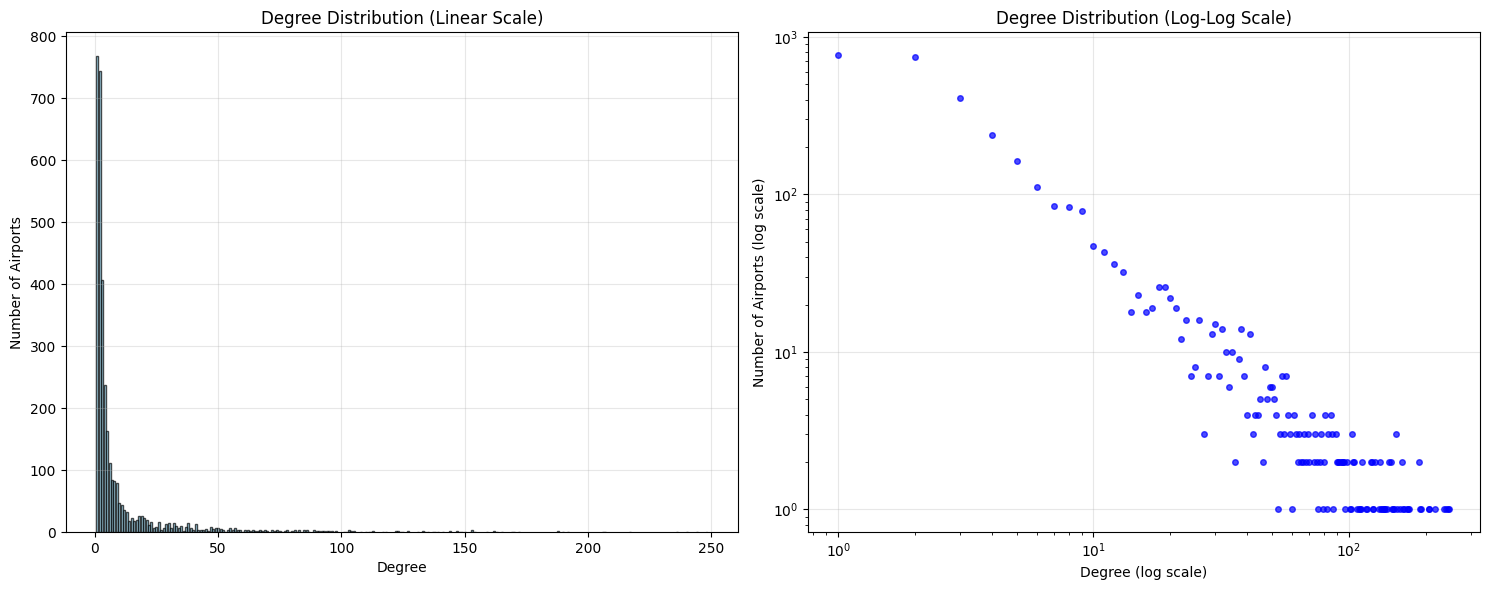


Degree Distribution Statistics:
Mean degree: 11.24
Median degree: 3.00
Max degree: 248
Min degree: 1
Standard deviation: 24.46


In [13]:
# Plot degree distribution
plot_degree_distribution(G)

## Centrality Measures Analysis

In [14]:
# Calculate centrality measures
centralities = calculate_centrality_measures(G)

Calculating centrality measures...
  - Degree centrality...
  - Betweenness centrality...
    (using sampling with k=1000 nodes)
  - Closeness centrality...
  - Eigenvector centrality...


## Top Airports by Centrality Measures

In [15]:
# Display top airports
display_top_airports(centralities, top_n=10)


TOP 10 AIRPORTS BY CENTRALITY MEASURES

DEGREE CENTRALITY:
----------------------------------------
 1. AMS  - 0.072430
 2. FRA  - 0.071262
 3. CDG  - 0.070093
 4. IST  - 0.068925
 5. ATL  - 0.063376
 6. PEK  - 0.060456
 7. ORD  - 0.060164
 8. MUC  - 0.056075
 9. DME  - 0.055491
10. DXB  - 0.054907

BETWEENNESS CENTRALITY:
----------------------------------------
 1. ANC  - 0.077936
 2. LAX  - 0.069063
 3. CDG  - 0.058649
 4. DXB  - 0.057573
 5. SEA  - 0.053310
 6. AMS  - 0.053302
 7. FRA  - 0.052145
 8. PEK  - 0.051752
 9. ORD  - 0.048060
10. YYZ  - 0.042938

CLOSENESS CENTRALITY:
----------------------------------------
 1. FRA  - 0.401846
 2. CDG  - 0.399388
 3. LHR  - 0.397332
 4. AMS  - 0.393056
 5. DXB  - 0.392692
 6. LAX  - 0.388825
 7. JFK  - 0.386744
 8. YYZ  - 0.382260
 9. IST  - 0.380206
10. ORD  - 0.379611

EIGENVECTOR CENTRALITY:
----------------------------------------
 1. AMS  - 0.167851
 2. FRA  - 0.166392
 3. CDG  - 0.159451
 4. MUC  - 0.148513
 5. FCO  - 0.136331
 6.

## Additional Analysis: Centrality Comparison

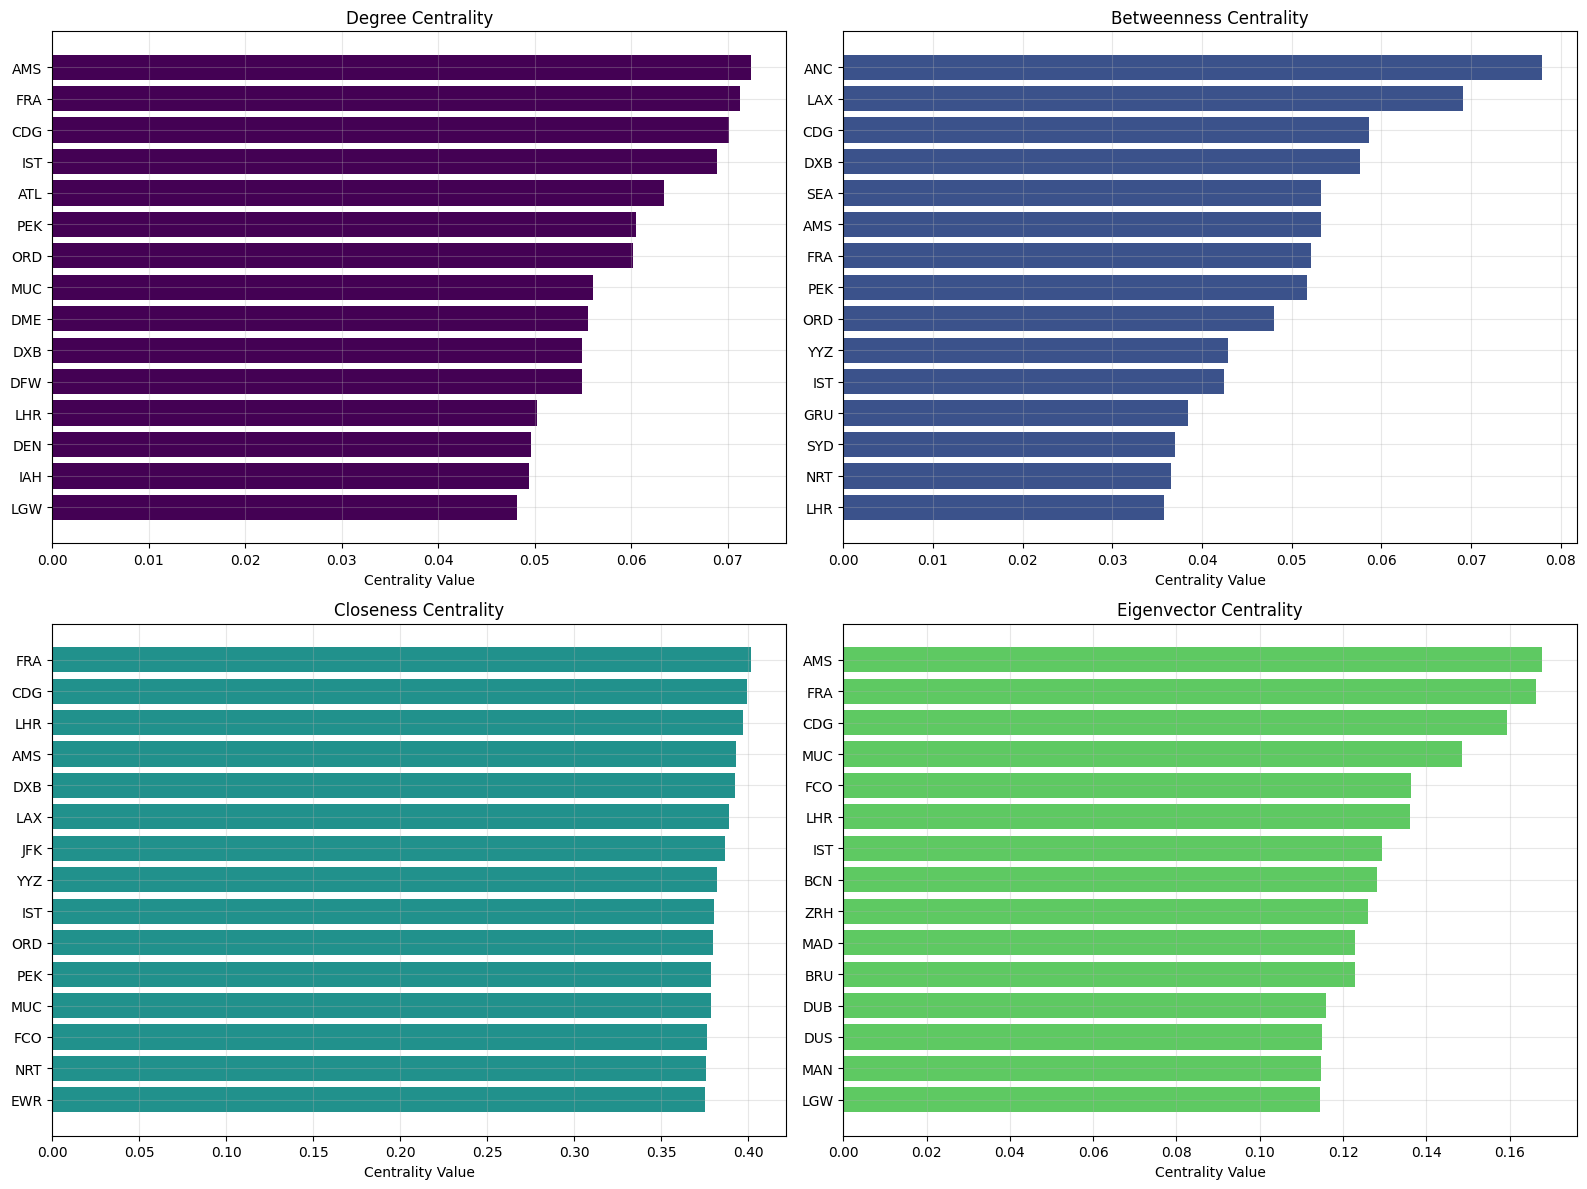

In [16]:
# Create a comparison plot of different centrality measures for top airports
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

centrality_names = ['degree', 'betweenness', 'closeness', 'eigenvector']
centrality_titles = ['Degree Centrality', 'Betweenness Centrality', 'Closeness Centrality', 'Eigenvector Centrality']

for i, (name, title) in enumerate(zip(centrality_names, centrality_titles)):
    # Get top 15 airports for this centrality measure
    sorted_airports = sorted(centralities[name].items(), key=lambda x: x[1], reverse=True)[:15]
    airports = [item[0] for item in sorted_airports]
    values = [item[1] for item in sorted_airports]
    
    # Create horizontal bar plot
    axes[i].barh(range(len(airports)), values, color=plt.cm.viridis(i/4))
    axes[i].set_yticks(range(len(airports)))
    axes[i].set_yticklabels(airports)
    axes[i].set_xlabel('Centrality Value')
    axes[i].set_title(title)
    axes[i].grid(True, alpha=0.3)
    
    # Invert y-axis to show highest values at top
    axes[i].invert_yaxis()

plt.tight_layout()
plt.savefig('centrality_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## Summary

This analysis provides comprehensive insights into the airline routes network:

1. **Network Structure**: The network shows typical characteristics of a real-world transportation network
2. **Degree Distribution**: Shows the connectivity patterns of airports
3. **Centrality Measures**: Identify the most important airports from different perspectives:
   - **Degree**: Most connected airports
   - **Betweenness**: Most important bridge airports
   - **Closeness**: Most centrally located airports
   - **Eigenvector**: Airports connected to other well-connected airports

The analysis reveals major international hubs like Amsterdam (AMS), Frankfurt (FRA), and Paris (CDG) consistently ranking high across different centrality measures.